In [49]:
from __future__ import print_function

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f'% x)

from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import pickle

In [14]:
df = pd.read_csv('data/analytical_base_table.csv')

In [15]:
y = df.status

X = df.drop('status', axis = 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   random_state = 1234,
                                                   stratify = df.status)

In [17]:
data = [X_train, X_test, y_train, y_test]

data_obs = [print(len(x)) for x in data]

11254
2814
11254
2814


In [21]:
pipelines = {
    'l1' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty = 'l1', random_state = 123)),
    'l2' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty = 'l2', random_state = 123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 123))
}

In [22]:
check = [print(k, type(v)) for k, v in pipelines.items()]

l1 <class 'sklearn.pipeline.Pipeline'>
l2 <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


In [33]:
pipelines['l1'].get_params()

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__n_jobs': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 123,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscal

In [34]:
pipelines['rf'].get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False))])>

In [36]:
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10)
}

rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33]     
}

gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [100, 200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth' : [1, 3, 5]
}

In [37]:
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [39]:
for k in ['l1', 'l2', 'rf', 'gb']:
    if k in hyperparameters:
        if type(hyperparameters[k]) is dict:
            print(k, 'found, and it is a grid.')
        else:
            print(k, 'found, but it is not a grid.')
    else:
        print(k, 'not found.')

l1 found, and it is a grid.
l2 found, and it is a grid.
rf found, and it is a grid.
gb found, and it is a grid.


In [42]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name],
                        cv = 10, n_jobs = -1)
    
    model.fit(X_train, y_train)
    
    fitted_models[name] = model
    
    print(name, 'has been fitted.')

l1 has been fitted.
l2 has been fitted.
rf has been fitted.
gb has been fitted.


In [43]:
check_1 = [print(k, type(v)) for k, v in fitted_models.items()]

l1 <class 'sklearn.model_selection._search.GridSearchCV'>
l2 <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [44]:
best_score = [print(name, model.best_score_) for name, model in fitted_models.items()]

l1 0.848942598187
l2 0.848942598187
rf 0.977430247023
gb 0.974942242758


In [48]:
predict = fitted_models['l1'].predict(X_test)
predict[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [51]:
confusion_matrix(y_test, predict)

array([[1969,  172],
       [ 219,  454]])

In [53]:
predict_prob = fitted_models['l1'].predict_proba(X_test)
predict_prob = [p[1] for p in predict_prob]
predict_prob[:10]

[0.030383883079074143,
 0.0044008701833427649,
 0.0072646034954551662,
 0.087317223691874113,
 0.070897016709157434,
 0.48347542970204921,
 0.12547338560928226,
 0.61884051370930615,
 0.72697592662759125,
 0.13534452540936395]

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, predict_prob)

In [56]:
pd.DataFrame({'FPR' : fpr, 'TPR' : tpr, 'Thresholds' : thresholds}).tail(10)

,FPR,TPR,Thresholds
532,0.759,0.994,0.010
533,0.785,0.994,0.008
534,0.785,0.996,0.008
535,0.909,0.996,0.002
536,0.909,0.997,0.002
537,0.931,0.997,0.001
538,0.931,0.999,0.001
539,0.950,0.999,0.001
540,0.950,1.000,0.001
541,1.000,1.000,0.000


_As the threshold decreases, both the false positive rate and the true positive rate increase._

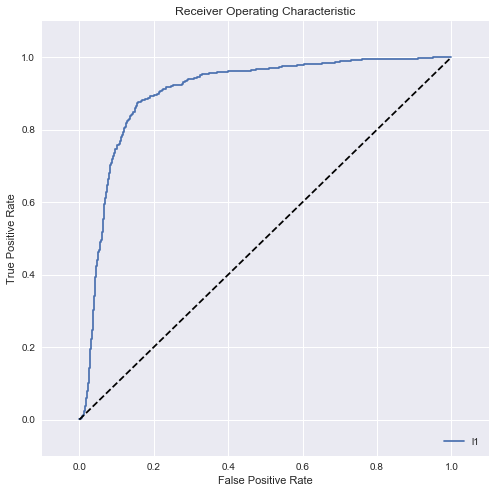

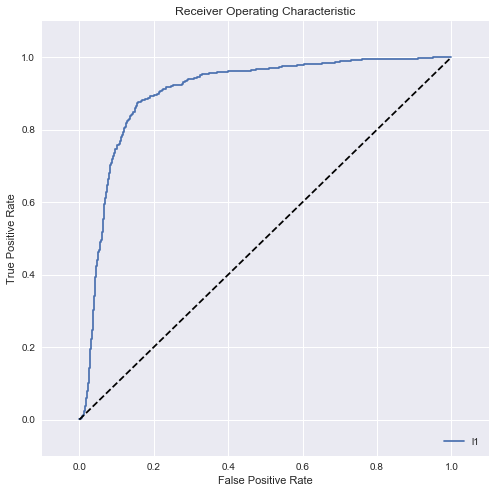

In [60]:
#initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

#plot ROC curve
plt.plot(fpr, tpr, label = 'l1')
plt.legend(loc = 'lower right')

#diagonal 45-degree line
plt.plot([0,1], [0,1], 'k--')

#Axes limits / labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()


In [61]:
fpr, tpr, thresholds = roc_curve(y_test, predict_prob)
print(auc(fpr, tpr))

0.901531897233


In [62]:
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(name, ': ', auc(fpr, tpr))

l1 :  0.901531897233
l2 :  0.901531897233
rf :  0.991540315624
gb :  0.987673616292


In [64]:
with open ('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)